# 210818 Create database

In [1]:
from pathlib import Path
import json
from string import ascii_uppercase

In [2]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import h5py as h5
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from gambit.kmers import KmerSpec, find_kmers
from gambit.metric import jaccarddist_sparse
from gambit.db.migrate import init_db
from gambit.db.models import ReferenceGenomeSet, Taxon, Genome, AnnotatedGenome
import gambit.io.json as gjson
from gambit.signatures import SignatureArray, SignaturesMeta
from gambit.signatures.hdf5 import HDF5Signatures

In [5]:
DATESTR = '210818'
DATESTR_LONG = '2021-08-18'

DBNAME = 'testdb_' + DATESTR
DBKEY = 'gambit/' + DBNAME

## File paths

In [6]:
outdir = Path('output')
outdir.mkdir(exist_ok=True)

In [7]:
tmpdir = Path('tmp')
tmpdir.mkdir(exist_ok=True)

## Funcs

In [8]:
NUC_BYTES = np.fromiter(map(ord, 'ACGT'), dtype=np.uint8)

In [9]:
def rand_seq(n):
    return bytearray(np.random.choice(NUC_BYTES, n))

In [10]:
def mutate_seq(a, n):
    """Randomly mutate sequence array in-place at n positions."""
    for i in np.random.choice(range(len(a)), n, replace=False):
        a[i] = np.random.choice(NUC_BYTES)

In [11]:
def make_mutations(a, m, n):
    """Make m mutated versions of an array a, each with n mutated positions."""
    for i in range(m):
        ma = bytearray(a)
        mutate_seq(ma, n)
        yield ma

In [12]:
def pw_dists(sigs):
    n = len(sigs)
    out = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i):
            out[i, j] = out[j, i] = jaccarddist_sparse(sigs[i], sigs[j])
    
    return out

## Parameter selection

In [13]:
SEQLEN = 5_000
kspec = KmerSpec(6, 'AT')

### Distribution of K-mer count

Verify this looks OK for choice of sequence length and k-mer spec.

In [14]:
counts = [len(find_kmers(kspec, rand_seq(SEQLEN))) for i in range(1000)]

<AxesSubplot:ylabel='Count'>

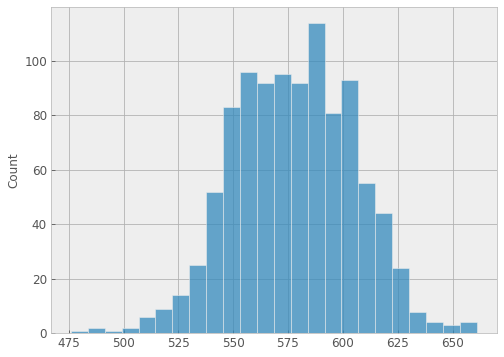

In [15]:
sns.histplot(counts)

### Choose mutation counts for clusters

Choose so that pairwise distances are at separate scales for each level

In [16]:
np.random.seed(0)
root_center = rand_seq(SEQLEN)

In [17]:
_dfs = []

for n in tqdm([5000, 2000, 1000, 500, 250, 100, 50, 25, 10]):
    sigs = [
        find_kmers(kspec, mut)
        for mut in make_mutations(root_center, 20, n)
    ]
    d = squareform(pw_dists(sigs))
    
    _dfs.append(pd.DataFrame(dict(dist_log=np.log10(d), n=np.repeat(n, len(d)))))
    
test_df = pd.concat(_dfs)
test_df.reset_index(inplace=True)

100%|██████████| 9/9 [00:02<00:00,  4.41it/s]


<AxesSubplot:xlabel='dist_log', ylabel='n'>

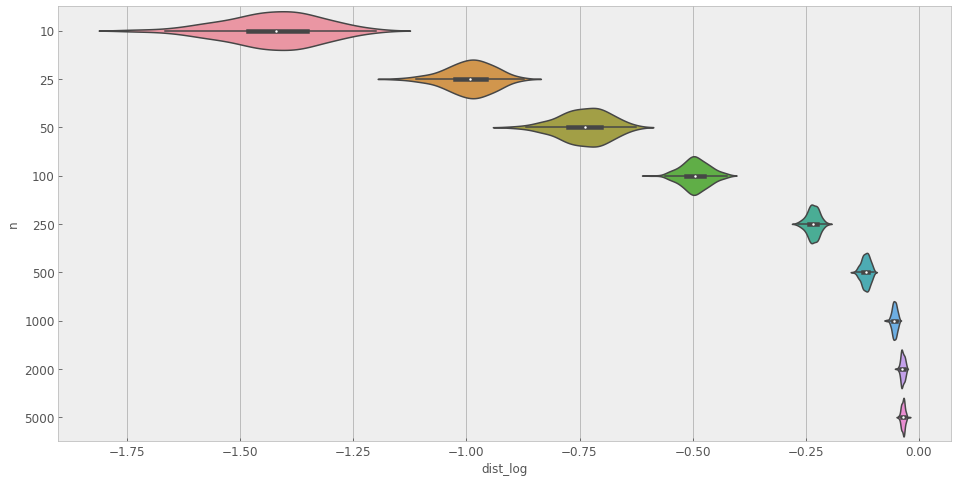

In [18]:
plt.figure(figsize=(16, 8))
sns.violinplot(data=test_df, x='dist_log', y='n', orient='h', scale='width')

In [19]:
N_VALS = [5000, 250, 100, 20]  # Number of mutations for each level
DEPTH = len(N_VALS) - 1
LEVEL_NAMES = list(ascii_uppercase[:DEPTH])

## Reference sequences and taxa

### Create taxon centers

In [20]:
CHILD_COUNTS = [3, 3, 4]  # Number of child taxa at each level

taxon_centers = {(): root_center}
_prev_level = dict(taxon_centers)

np.random.seed(0)

for level, n_children in enumerate(CHILD_COUNTS):
    _next_level = dict()
    
    for parent_key, parent_arr in _prev_level.items():
        for i, mut in enumerate(make_mutations(parent_arr, n_children, N_VALS[level])):
            key = (*parent_key, i)
            _next_level[key] = mut
    
    
    taxon_centers.update(_next_level)
    _prev_level = _next_level

### Enumerate taxa

In [21]:
taxon_keys = sorted(taxon_centers)
len(taxon_keys)

49

In [22]:
key_to_index = {key: i for i, key in enumerate(taxon_keys)}

In [23]:
taxa_by_level = [[] for d in range(DEPTH + 1)]

for k in taxon_keys:
    taxa_by_level[len(k)].append(k)
    
list(map(len, taxa_by_level))

[1, 3, 9, 36]

### Taxa table

In [24]:
_rows = [
    (
        '_'.join(f'{lname}{i + 1}' for lname, i in zip(LEVEL_NAMES, key)) if key else 'root',
        len(key),
    )
    for key in taxon_keys
]

taxa_df = pd.DataFrame.from_records(_rows, columns=['name', 'level'])

In [25]:
taxa_df['key'] = [f'{DBKEY}/{name}' for name in taxa_df['name']]

In [26]:
taxa_df['parent'] = [taxa_df.loc[key_to_index[key[:-1]], 'name'] if key else None for key in taxon_keys]

In [27]:
RANKS = ['genus', 'species', 'strain']

taxa_df['rank'] = [RANKS[l - 1] if l > 0 else None for l in taxa_df['level']]

In [28]:
taxa_df['report'] = True
taxa_df['notes'] = None

### Create sequences

In [29]:
SEQ_COUNTS = [0, 3, 3, 5]  # Number to create for taxa at each level

ref_seqs = []
ref_taxa = []
ref_names = []

np.random.seed(0)

for key, taxon in zip(taxon_keys, taxa_df.itertuples()):
    level = len(key)
    center = taxon_centers[key]
    n_seq = SEQ_COUNTS[level]
    n_mut = N_VALS[level]
    
    for i, mut in enumerate(make_mutations(center, n_seq, n_mut)):
        ref_seqs.append(mut)
        ref_taxa.append(key)
        ref_names.append(f'{taxon.name}-{i+1}')
        
len(ref_seqs)

216

In [30]:
ref_sigs = [find_kmers(kspec, seq) for seq in ref_seqs]

In [31]:
ref_indices_by_taxon = {
    key: [
        i for i, owner_key in enumerate(ref_taxa)
        if owner_key[:len(key)] == key
    ]
    for key in taxon_keys
}

In [32]:
refs_df = pd.DataFrame.from_dict(dict(name=ref_names))
refs_df['key'] = [f'{DBKEY}/{name}' for name in ref_names]
refs_df['taxon'] = [taxa_df.loc[key_to_index[key], 'name'] for key in ref_taxa]
refs_df['export'] = True

### Pairwise distances

In [33]:
ref_pw_dists = pw_dists(ref_sigs)

In [34]:
assert not np.any(ref_pw_dists == 1)

In [35]:
_diameters = []

for key in taxon_keys:
    indices = ref_indices_by_taxon[key]
    d = ref_pw_dists[np.ix_(indices, indices)].max()
    _diameters.append(d)

taxa_df['diameter'] = _diameters

In [36]:
taxa_min_dists_by_level = []

for keys in taxa_by_level:
    n = len(keys)
    d = np.zeros((n, n))
    
    for i, k1 in enumerate(keys):
        ii = ref_indices_by_taxon[k1]
        for j, k2 in enumerate(keys):
            jj = ref_indices_by_taxon[k2]
            d[i, j] = ref_pw_dists[np.ix_(ii, jj)].min()
    
    taxa_min_dists_by_level.append(d)

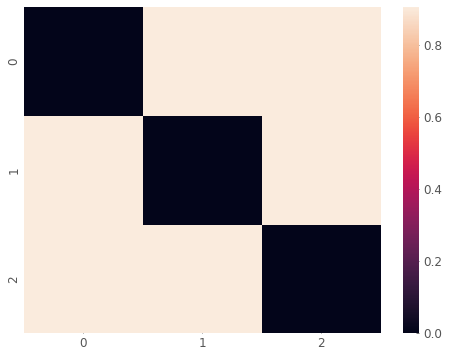

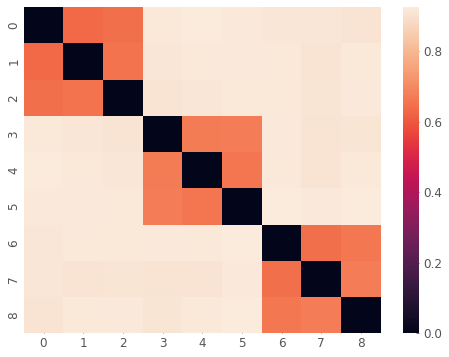

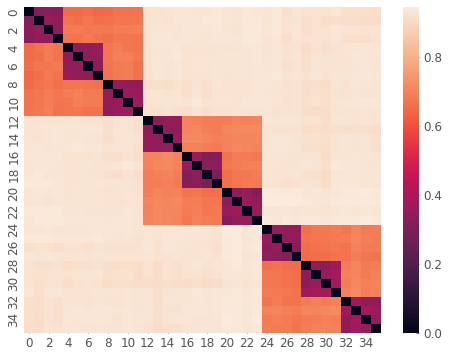

In [37]:
for d in taxa_min_dists_by_level[1:]:
    plt.figure()
    sns.heatmap(d)

### Check for overlaps using diameter as threshold

In [38]:
taxa_min_inter = dict()

for keys, d in zip(taxa_by_level[1:], taxa_min_dists_by_level[1:]):
    for i, key in enumerate(keys):
        taxa_min_inter[key] = np.delete(d[i, :], i).min()
        
taxa_df['min_inter'] = [taxa_min_inter.get(key, float('nan')) for key in taxon_keys]

In [39]:
for row in taxa_df.itertuples():
    if row.name != 'root':
        assert row.diameter < row.min_inter

In [40]:
taxa_df['threshold'] = taxa_df['diameter']

## Special cases

### No-threshold taxon

Set taxon A1_B1 to no threshold, classification only happens on genomes of child taxa.

In [41]:
_key = (0, 0)
_index = key_to_index[_key]
_name = taxa_df.loc[_index, 'name']

taxa_df.loc[_index, 'threshold'] = float('nan')
taxa_df.loc[_index, 'notes'] = 'No threshold'

Also set children to `report=False`

In [42]:
_childrows = taxa_df['parent'] == _name
taxa_df.loc[_childrows, 'report'] = False
taxa_df.loc[_childrows, 'notes'] = "Don't report"

Don't export genomes

In [43]:
refs_df.loc[refs_df['taxon'] == _name, 'export'] = False

### High threshold

Raise threshold of taxon A2_B1 to higher value, this enables:
* Inconsistent matches with this and another taxon in A2_B2/A2_B3
* Match to only this taxon but closer to genome in A2_B2/A2_B3

In [44]:
_key = (1, 0)
_index = key_to_index[_key]

taxa_df.loc[_index]

name                              A2_B1
level                                 2
key          gambit/testdb_210818/A2_B1
parent                               A2
rank                            species
report                             True
notes                              None
diameter                       0.411846
min_inter                      0.668998
threshold                      0.411846
Name: 18, dtype: object

In [45]:
taxa_df.loc[_index, 'threshold'] = taxa_df.loc[_index, 'min_inter'] * .95
taxa_df.loc[_index, 'notes'] = 'High threshold'

## Create genome database

### Initialize

In [46]:
dbfile = outdir / (DBNAME + '-genomes.db')
if dbfile.is_file():
    dbfile.unlink()

In [47]:
engine = create_engine('sqlite:///%s' % dbfile)
Session = sessionmaker(engine)

In [48]:
init_db(engine)

In [49]:
session = Session()

### Genome set

In [50]:
genome_set = ReferenceGenomeSet(
    key=DBKEY,
    version='1.0',
    name=DBNAME,
    description='Database containing artificial genomes, to be used for end-to-end testing',
    extra=dict(
        date_created=DATESTR_LONG,
        author='Jared Lumpe',
    ),
)

session.add(genome_set)

### Taxa

In [51]:
taxa = dict()

for key, row in zip(taxon_keys, taxa_df.itertuples()):
    if not key:
        continue  # Don't include root taxon

    taxon = Taxon(
        key=row.key,
        name=row.name,
        rank=row.rank,
        parent=taxa.get(key[:-1]),
        genome_set=genome_set,
        distance_threshold=row.threshold,
        report=True,
    )

    taxa[key] = taxon
    session.add(taxon)

### Genomes 

In [52]:
for taxon_key, row in zip(ref_taxa, refs_df.itertuples()):
    if not row.export:
        continue

    genome = Genome(
        key=row.key,
        description=row.name,
    )
    
    a = AnnotatedGenome(
        genome_set=genome_set,
        genome=genome,
        taxon=taxa[taxon_key],
    )
    
    session.add(genome)
    session.add(a)

### Finish

In [53]:
session.commit()

## Save data

### Tables

In [54]:
_cols = ['name', 'key', 'parent', 'level', 'rank', 'report', 'diameter', 'min_inter', 'threshold', 'notes']
taxa_df[_cols].to_csv(tmpdir / 'taxa.csv', index=False)

In [55]:
refs_df.loc[refs_df['export'], ['name', 'key', 'taxon']].to_csv(tmpdir / 'ref-genomes.csv', index=False)

### Genome sequences

In [56]:
center_records = [
    SeqRecord(Seq(taxon_centers[key]), id=taxon.name, name='', description='')
    for key, taxon in zip(taxon_keys, taxa_df.itertuples())
]

SeqIO.write(center_records, str(tmpdir / 'taxon-centers.fasta'), 'fasta')

49

In [57]:
ref_records = [
    SeqRecord(Seq(seq), id=row.name, name='', description='')
    for seq, row in zip(ref_seqs, refs_df.itertuples())
    if row.export
]

SeqIO.write(ref_records, str(tmpdir / 'ref-genomes.fasta'), 'fasta')

213

### Signatures

In [58]:
meta = SignaturesMeta(
    id=DBKEY,
    name=DBNAME,
    version='1.0',
    description=genome_set.description,
    id_attr='key',
    extra=dict(
        date_created=DATESTR_LONG,
        author='Jared Lumpe',
    ),
)

In [59]:
ref_sigarray = SignatureArray([s for s, row in zip(ref_sigs, refs_df.itertuples()) if row.export], dtype=kspec.coords_dtype)
ref_keys = refs_df.loc[refs_df['export'], 'key']

In [60]:
with h5.File(outdir / f'{DBNAME}-signatures.h5', 'w') as f:
    HDF5Signatures.create(f, kspec, ref_sigarray, ref_keys, meta)

### Other

Stuff for other notebooks

In [61]:
params = dict(
    n_mutations=N_VALS,
    kmerspec=kspec,
)

with open(tmpdir / 'params.json', 'wt') as f:
    gjson.dump(params, f)